# Skillbox — Мастер-класс: Разведочный анализ данных + Подготовка отчётов — Kiva.org
***

# Новый раздел

# 4. Домашнее задание
***

# Подготовка данных

In [29]:
import numpy as np
import pandas as pd
import math
import missingno as msno
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set2')

In [30]:
df_kiva_loans = pd.read_csv("D:/files/kiva_loans.csv")
df_mpi = pd.read_csv("D:/files/kiva_mpi_region_locations.csv")

In [31]:
countries = df_kiva_loans['country'].value_counts()[df_kiva_loans['country'].value_counts(normalize=True)> 0.005]
list_countries = list(countries.index)
df_mpi_grouped = df_mpi\
    .groupby(['ISO', 'country', 'world_region'])['MPI']\
    .mean()\
    .fillna(0)\
    .reset_index()
df_kiva_loans = df_kiva_loans.merge(df_mpi_grouped, how='left', on='country')
# regions = df_kiva_loans['world_region'].value_counts()
# regions_list = regions.index.to_list()
df_kiva_loans['borrower_genders'] = [elem if elem in ['female','male'] else 'group' for elem in df_kiva_loans['borrower_genders'] ]


In [32]:
df_gender_by_country = \
    df_kiva_loans[df_kiva_loans['country'].isin(countries.index.values)]\
    .groupby(['country', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)\

df_gender_by_country = df_gender_by_country[['male', 'group', 'female' ]]

# Наблюдаемое отклонение от среднего
dev = (df_kiva_loans['loan_amount']-df_kiva_loans['loan_amount'].mean()).abs()
# Стандартное отклонение
std = df_kiva_loans['loan_amount'].std()
# Фильтруем исходный набор данных
df_kiva_loans_trimmed = df_kiva_loans[~(dev>3*std)]

# В каких странах преобладают мужчины? Группа людей? (п. 2.2.2.)

In [33]:
print('Страны где преобладают мужчины:')
df_gender_by_country[(df_gender_by_country.male > df_gender_by_country.female) &
                     (df_gender_by_country.male > df_gender_by_country.group)
]\
    .sort_values(by='male', ascending=False)

Страны где преобладают мужчины:


borrower_genders,male,group,female
country,,,
Nigeria,87.134964,0.878058,11.986977
Palestine,64.601445,0.183666,35.214889
Uganda,48.701519,11.421776,39.876705
Mexico,34.767462,30.743773,34.488765


In [34]:
print('Страны где преобладают группы:')
df_gender_by_country[(df_gender_by_country.group> df_gender_by_country.female) &
                     (df_gender_by_country.group> df_gender_by_country.male)
]\
    .sort_values(by='group', ascending=False)

Страны где преобладают группы:


borrower_genders,male,group,female
country,,,
Mali,4.835066,91.836120,3.328815
Cambodia,5.368010,73.682398,20.949592
Guatemala,20.314637,62.640219,17.045144
Tanzania,10.346810,59.149262,30.503928
Ghana,16.095107,57.933242,25.971651
Paraguay,19.129631,55.053348,25.817021
Rwanda,22.865627,42.746845,34.387528


# Изучите несколько займов с очень большими суммами. Что можно сказать о назначении этих заявок? В каких странах они оформлены? Каков гендерный состав заявителей? (п. 2.4.2.)

In [35]:
df_high_loan = df_kiva_loans[df_kiva_loans.loan_amount >= 50000]

Назначение займов свыше 50000:

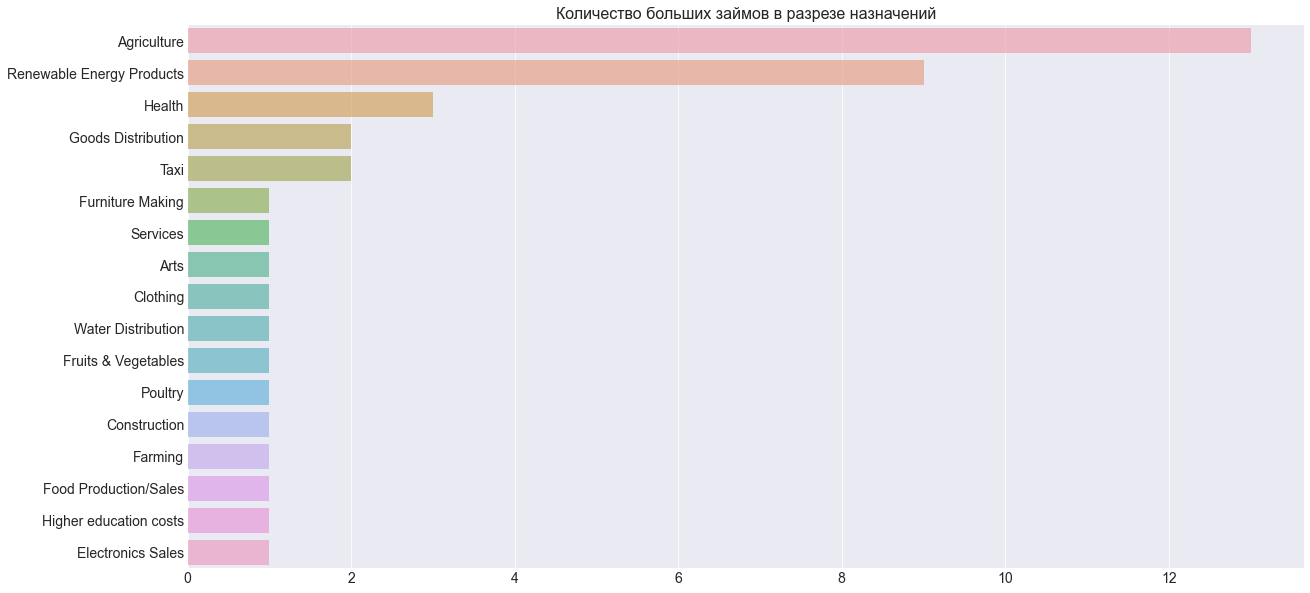

,sector,use,max_loan
0,Agriculture,create more than 300 jobs for women and farmer...,100000.0
1,Agriculture,To pay smallholder coffee farmers in rural Ken...,50000.0
2,Retail,to distribute 400 pay-as-you-go solar systems ...,50000.0
3,Health,to provide community trauma services in South ...,50000.0
4,Manufacturing,create jobs through environmentally-friendly m...,50000.0
5,Retail,To buy and sell Barefoot Power solar lighting.,50000.0
6,Retail,To buy and sell Barefoot Power's solar lightin...,50000.0
7,Retail,to buy and sell Barefoot Power's Solar Lightin...,50000.0
8,Retail,to distribute 200+ innovative & affordable pay...,50000.0
9,Retail,to distribute 400 pay-as-you-go solar home sys...,50000.0


In [36]:
high_loan_activity = df_high_loan['activity'].value_counts()

plt.figure(figsize=(20,10))
plt.title("Количество больших займов в разрезе назначений", fontsize=16)
plt.tick_params(labelsize=14)
sns.barplot(y=high_loan_activity.index, x=high_loan_activity.values, alpha=0.6)
plt.show()

df_high_loan.groupby(['sector', 'use'])['loan_amount']\
    .agg(max_loan = 'max')\
    .sort_values('max_loan', ascending=False)\
    .reset_index()[:10]

Страны и регионы в которых эти займы были оформлены:

In [48]:
df_high_loan['country'].value_counts()

Kenya            7
Peru             4
Ghana            4
Mexico           4
Uganda           3
Haiti            3
Tanzania         2
Indonesia        1
Zimbabwe         1
Cote D'Ivoire    1
Guatemala        1
Malawi           1
Pakistan         1
Benin            1
Zambia           1
Madagascar       1
Ecuador          1
Albania          1
South Sudan      1
Mozambique       1
Rwanda           1
Name: country, dtype: int64


Гендерный состав заявителей:

In [40]:
df_high_loan['borrower_genders'].value_counts()

[22, 14, 5]

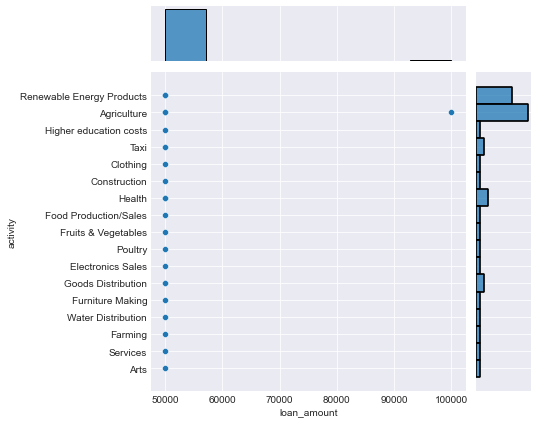

In [39]:
# plt.figure(figsize=(20,10))
# plt.title("Суммы займов по секторам", fontsize=18)
# plt.xticks(np.arange(0, max(df_high_loan['loan_amount']+1), 10000))
# plt.tick_params(labelsize=14)
#
# sns.boxplot(x='loan_amount', y="sector", data=df_high_loan ).set(ylabel=None, xlabel=None)
# plt.show()
# sns.distplot(df_high_loan ['total_bill'], kde=False, bins=30);
sns.jointplot(x='loan_amount', y='activity', data=df_high_loan , kind='scatter')
# plt.figure(figsize=(20,10))
# plt.title("Количество займов в разрезе стран", fontsize=16)
# plt.tick_params(labelsize=14)
# sns.barplot(y=df_high_loan.activity, x=df_high_loan.value_counts(), alpha=0.6)
# plt.show()

## 4.1. Самостоятельная работа
***

- А в каких странах преобладают мужчины? Группа людей? (п. 2.2.2.)
- Изучите несколько займов с очень большими суммами. Что можно сказать о назначении этих заявок? В каких странах они оформлены? Каков гендерный состав заявителей? (п. 2.4.2.)
- Попробуйте найти связь между странами (регионами), полом заёмщика и суммой заявки. Какие выводы можно сделать из этих данных? (п. 2.4.3.)

## 4.2. Домашняя работа
***

Расширьте наш отчёт исследованием следующих вопросов:

- Зависимость пола заёмщика от региона планеты, сектора экономики.
- Влияние такого атрибута займа, как **Количество кредиторов** (lender_count), на суммы и сроки займов.
- Влияние показателя **MPI** (многомерный индекс бедности) в разных странах на суммы займов и сроки погашения.
- Зависимости таких метрик, как «Сумма займа», «Срок займа», «Время финансирования заявки», «Ежемесячный платёж», в разрезе **макрорегионов**.